In [1]:
import rioxarray as rx
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import os
import scipy.optimize as optimize
os.chdir('/disk/scratch/local.4/harry/TDX/intensity/nc')

In [21]:
# Read in data and define cumulative sum of residual function
asc = xr.open_dataset('ascending.nc')
desc = xr.open_dataset('descending.nc')

def CSR(a):
    mean = np.mean(a, axis=0)
    resid = a - mean
    return np.cumsum(resid,axis=0)

def get_CSR(a):
    return xr.apply_ufunc(CSR, a)

In [22]:
## What about weighting the intensity to avoid bias in middle of timeseries...
def get_weights(a):
    N = a.shape[0]
    T = np.indices(a.shape)[0]
    return T*(1-T/N)

def CSR_weighted(a):
    mean = np.mean(a,axis=0)
    resid = a - mean
    cumsum = np.divide( np.cumsum(resid,axis=0) , get_weights(a) )
    return cumsum#[1:-1]

def get_CSR_weighted(a):
    return xr.apply_ufunc(CSR_weighted, a).isel(t=slice(1,-1))


In [23]:
## Intervention! Increase pixel size BEFORE calculating CSR
# Found this worsened results.
asc = asc.coarsen(lat=2,lon=2,boundary='trim').mean()
desc= desc.coarsen(lat=2,lon=2,boundary='trim').mean()

In [24]:
# Calculate CSRs and combine with UAV data into a single dataset
csr_Aw = get_CSR_weighted(asc).intensity.rename('Aw')
csr_Dw = get_CSR_weighted(desc).intensity.rename('Dw')
csr_A = get_CSR(asc).intensity.rename('A').isel(t=slice(1,-1))
csr_D = get_CSR(desc).intensity.rename('D').isel(t=slice(1,-1))
csr = xr.merge([csr_D,
                csr_A.interp(lat=csr_D.lat,lon=csr_D.lon),
               csr_Aw.interp(lat=csr_D.lat,lon=csr_D.lon),
               csr_Dw.interp(lat=csr_D.lat,lon=csr_D.lon)])
UAV = '/exports/csce/datastore/geos/users/s1332488/Chapter3/intensity/UAV_change_1m_masked.tif'
uav = rx.open_rasterio(UAV).sel(band=1).drop('band').rio.reproject('EPSG:4326').rename({'x':'lon','y':'lat'})
uav = uav.where(uav > -100).interp_like(csr).rename('uav')
ds = xr.merge([csr,uav])
## Dataset containing UAV change and intensity Cumalitve sums of residuals for both passes 
## all on the same grid
ds

/home/s1332488/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


<xarray.Dataset>
Dimensions:      (t: 31, lat: 1315, lon: 1618)
Coordinates:
  * t            (t) datetime64[ns] 2019-06-27T10:19:04 ... 2021-06-30T22:56:21
  * lat          (lat) float64 -11.0 -11.0 -11.0 -11.0 ... -11.06 -11.06 -11.06
  * lon          (lon) float64 -69.76 -69.76 -69.76 ... -69.68 -69.68 -69.68
    spatial_ref  int64 0
Data variables:
    D            (t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    A            (t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    Aw           (t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    Dw           (t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    uav          (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan

Text(0.5, 0, 'UAV height change')

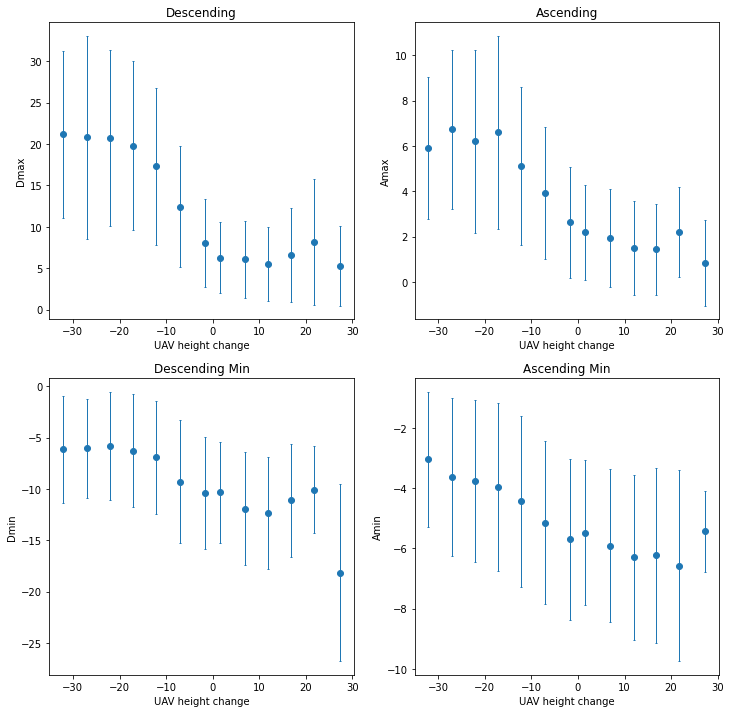

In [26]:
## First look at the data 

ds['Amax'] = ds.A.max(dim='t')
ds['Dmax'] = ds.D.max(dim='t')
ds['Awmax'] = ds.Aw.max(dim='t')
ds['Dwmax'] = ds.Dw.max(dim='t')
####################################
binned = ds[['Dmax','Amax','uav']].groupby_bins('uav',np.arange(-35,35,5))
ds['Amin'] = ds.A.min(dim='t')
ds['Dmin'] = ds.D.min(dim='t')
binnedMIN = ds[['Dmin','Amin','uav']].groupby_bins('uav',np.arange(-35,35,5))

plt.figure(figsize=(12,12))

plt.subplot(2,2,1)
plt.title('Descending')
yerr = binned.std().Dmax
x = binned.mean().uav
y = binned.mean().Dmax
plt.errorbar(x,y,yerr=yerr/2,lw=0,elinewidth = 1,capsize=1,marker='o')
plt.ylabel('Dmax')
plt.xlabel('UAV height change')
#plt.axvline(x=-10,color='black')

plt.subplot(2,2,2)
plt.title('Ascending')
yerr = binned.std().Amax
x = binned.mean().uav
y = binned.mean().Amax
plt.errorbar(x,y,yerr=yerr/2,lw=0,elinewidth = 1,capsize=1,marker='o')
plt.ylabel('Amax')
plt.xlabel('UAV height change')

plt.subplot(2,2,3)
plt.title('Descending Min')
yerr = binnedMIN.std().Dmin
x = binnedMIN.mean().uav
y = binnedMIN.mean().Dmin
plt.errorbar(x,y,yerr=yerr/2,lw=0,elinewidth = 1,capsize=1,marker='o')
plt.ylabel('Dmin')
plt.xlabel('UAV height change')

plt.subplot(2,2,4)
plt.title('Ascending Min')
yerr = binnedMIN.std().Amin
x = binnedMIN.mean().uav
y = binnedMIN.mean().Amin
plt.errorbar(x,y,yerr=yerr/2,lw=0,elinewidth = 1,capsize=1,marker='o')
plt.ylabel('Amin')
plt.xlabel('UAV height change')


In [27]:
## The quantified analysis is below ---------------
def analyse(C,weighted=False): # C is coarsening factor
    if weighted == False:
        cutoffD = ds.Dmax.where(ds.uav>0).mean().values
        cutoffA = ds.Amax.where(ds.uav>0).mean().values # Get rid of some noise

        ds_loss = xr.merge([( (ds.Dmax - cutoffD) * (ds.Dmax > cutoffD) ).rename('Dmax_filt'),
                            ( (ds.Amax - cutoffA) * (ds.Amax > cutoffA) ).rename('Amax_filt'),
                            (ds.uav).rename('uav_change')])
    elif weighted == True:
        cutoffD = ds.Dwmax.where(ds.uav>0).mean().values
        cutoffA = ds.Awmax.where(ds.uav>0).mean().values # Get rid of some noise

        ds_loss = xr.merge([( (ds.Dwmax - cutoffD) * (ds.Dwmax > cutoffD) ).rename('Dmax_filt'),
                            ( (ds.Awmax - cutoffA) * (ds.Awmax > cutoffA) ).rename('Amax_filt'),
                            (ds.uav).rename('uav_change')])        
    # ds_loss['combined'] = ds_loss.Dmax_filt * ds_loss.Amax_filt
    # cutoffAD = ds_loss.combined.where(ds_loss.uav_change >0).mean().values
    #ds_loss['combined'] = (ds_loss.combined - cutoffAD)*(ds_loss.combined > cutoffAD) # reduce noise again
    else:
        raise('Please specify True or False for weighting')
        
    ds_loss = ds_loss.coarsen(lat=C,lon=C,boundary='trim').mean(skipna=False) 

    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    plt.title('Descending')
    ds_loss.plot.scatter(x='uav_change',y='Dmax_filt',s=4)

    plt.subplot(1,2,2)
    plt.title('Ascending')
    ds_loss.plot.scatter(x='uav_change',y='Amax_filt',s=4)

    # plt.subplot(1,3,3)
    # plt.title('Combined')
    # ds_loss.plot.scatter(x='uav_change',y='combined',s=4)

    plt.show()
    print('Correlations')
    print('D',xr.corr(ds_loss.uav_change,ds_loss.Dmax_filt).values)
    print('A',xr.corr(ds_loss.uav_change,ds_loss.Amax_filt).values)
    #plt.ylim(0,1)
    #plt.xlim(-10,10)
    plt.show()

    def cost_fn(p):
        estimate = p[0]*ds_loss.Dmax_filt + p[1]*ds_loss.Amax_filt + p[2]
        rmsq = np.sqrt( ((estimate-ds_loss.uav_change)**2).sum() )
        return rmsq

    p = optimize.minimize(cost_fn,[1,1,1]).x
    ds_loss['estimate'] = p[0]*ds_loss.Dmax_filt + p[1]*ds_loss.Amax_filt + p[2]

    plt.figure(figsize=(10,7))
    ds_loss.plot.scatter(x='uav_change',y='estimate',s=5)
    #plt.plot([-7,3],[-7,3],color='black')
    plt.axvline(x=0,alpha=0.2,color='grey')
    plt.axhline(y=0,alpha=0.2,color='grey')
    plt.savefig('/home/s1332488/Chapter3/Figures/I_change/I_change.png')
    plt.show() ########################
    ds_loss.estimate.rio.to_raster('/home/s1332488/Chapter3/Figures/I_change/estimate.tiff')
    print('CORR',xr.corr(ds_loss.uav_change,ds_loss.estimate).values)


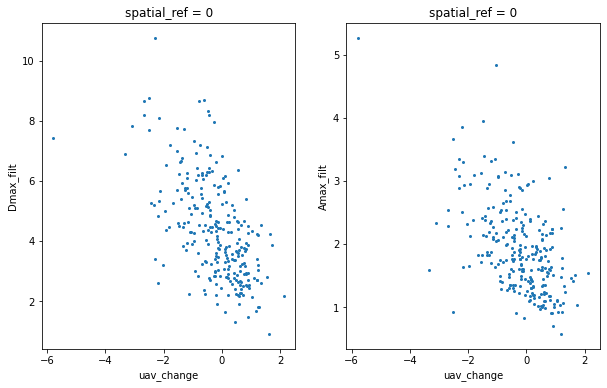

Correlations
D -0.5976129529396842
A -0.5455777942809837


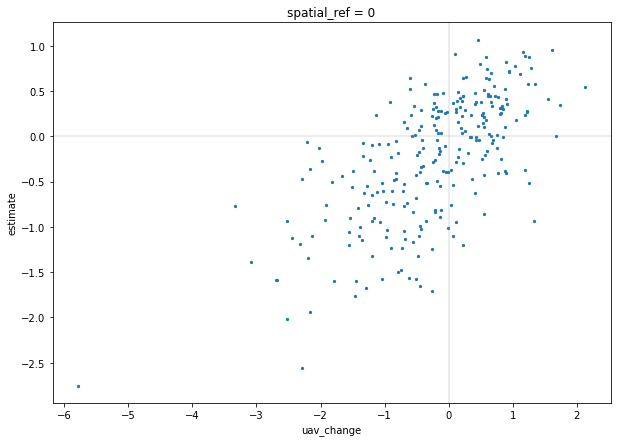

CORR 0.6714977771669801


In [29]:
analyse(15,weighted=False)

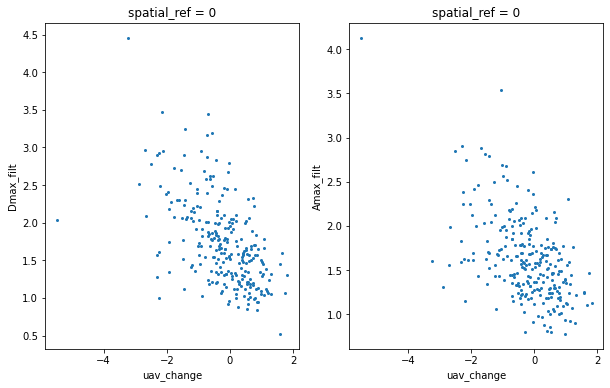

Correlations
D -0.5544271632676852
A -0.5310343530094752


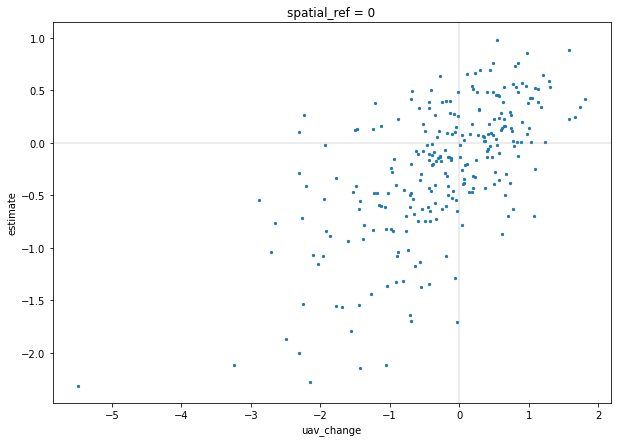

CORR 0.6369492550856366


In [66]:
analyse(30,weighted=True)

In [412]:
ds_loss.estimate.rio.to_raster('/exports/csce/datastore/geos/users/s1332488/Chapter3/intensity/estimate.tiff')

In [413]:
ds_loss.uav_change.rio.to_raster('/exports/csce/datastore/geos/users/s1332488/Chapter3/intensity/uav_change.tiff')